In [48]:
import numpy as np
import pandas as pd
from collections import Counter
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
train_data = np.load('bal/training_data-2.npy')
df = pd.DataFrame(train_data)
print(df.head())
print(Counter(df[1].apply(str)))

                                                   0  \
0  [[[238, 204, 171], [246, 231, 216], [72, 62, 5...   
1  [[[238, 204, 171], [247, 231, 217], [115, 132,...   
2  [[[238, 204, 171], [246, 231, 216], [120, 139,...   
3  [[[238, 204, 171], [246, 231, 216], [74, 69, 5...   
4  [[[238, 204, 171], [246, 231, 216], [74, 67, 5...   

                             1  
0  [0, 0, 0, 0, 1, 0, 0, 0, 0]  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0]  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0]  
3  [0, 0, 0, 0, 1, 0, 0, 0, 0]  
4  [0, 0, 0, 0, 1, 0, 0, 0, 0]  
Counter({'[0, 0, 0, 0, 0, 0, 0, 0, 0]': 93, '[1, 0, 0, 0, 0, 0, 0, 0, 0]': 93, '[0, 0, 0, 0, 0, 0, 0, 1, 0]': 84, '[0, 0, 0, 0, 0, 1, 0, 0, 0]': 66, '[0, 0, 1, 0, 0, 0, 0, 0, 0]': 65, '[0, 0, 0, 0, 1, 0, 0, 0, 0]': 51, '[0, 0, 0, 1, 0, 0, 0, 0, 0]': 47, '[0, 0, 0, 0, 0, 0, 1, 0, 0]': 40})


In [50]:
key_map = {
    'W': [1, 0, 0, 0, 0, 0, 0, 0, 0],
    'S': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'A': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'D': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'WA': [0, 0, 0, 0, 1, 0, 0, 0, 0],
    'WD': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'SA': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'SD': [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'NK': [0, 0, 0, 0, 0, 0, 0, 0, 1],
    'default': [0, 0, 0, 0, 0, 0, 0, 0, 0],
}

In [51]:
def show_saved_data(idx):
    imgplot = plt.imshow(train_data[idx][0])
    print(train_data[idx][1])

def get_saved_data(idx):
    return train_data[idx][0].copy(),train_data[idx][1].copy()

[0, 0, 0, 0, 0, 0, 0, 0, 0]


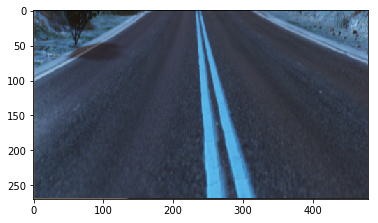

In [52]:
show_saved_data(300)

In [53]:
import cv2
from numpy import ones,vstack
from numpy.linalg import lstsq
from statistics import mean


In [54]:
def roi(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [55]:
def draw_lines(img,lines):
    for line in lines:
        coords = line[0]
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 3)

In [56]:
cv2.HoughLinesP?

In [57]:
def detect_edge(rgb_image):
    #gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)   
    processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)
    #processed_img = cv2.Canny(gray_img, threshold1=200, threshold2=300)
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
    vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
    processed_img = roi(processed_img, [vertices])
    plt.imshow(processed_img)    
    
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
    #print(lines)
    #draw_lines(processed_img,lines)    
    return processed_img, lines

In [58]:
def display_image_win(pos,img):
    cv2.imshow(pos, img)

def destroy_win():    
    while True:
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break    

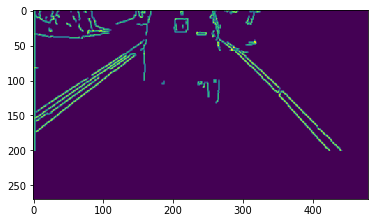

In [59]:
img, action = get_saved_data(32)
display_image_win('window',img)
new_screen, hlines= detect_edge(img)
#display_image_win('window2',gray_img)
display_image_win('window2',new_screen)
draw_lines(new_screen,hlines)    
display_image_win('window3',new_screen)

destroy_win()

In [86]:
def draw_lanes(img, lines, color=[0, 255, 255], thickness=3):

    # if this fails, go with some default line
    try:
        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

        ys = []  
        for i in lines:
            for ii in i:
                ys += [ii[1],ii[3]]
        #print(lines)
        min_y = min(ys)
        max_y = 270
        new_lines = []
        line_dict = {}

        for idx,i in enumerate(lines):
            for xyxy in i:
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Calculating our new, and improved, xs
                x1 = (min_y-b) / m
                x2 = (max_y-b) / m

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}

        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:
                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:2]

        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s))

        l1_x1, l1_y1, l1_x2, l1_y2 = average_lane(final_lanes[lane1_id])
        l2_x1, l2_y1, l2_x2, l2_y2 = average_lane(final_lanes[lane2_id])

        return [l1_x1, l1_y1, l1_x2, l1_y2], [l2_x1, l2_y1, l2_x2, l2_y2]
    except Exception as e:
        print(str(e))

In [97]:
abs(-39)
#cv2.circle?

39

In [94]:
def display_lanes(rgb_image):
    original_image = rgb_image   
    #gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
    vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
    processed_img = roi(processed_img, [vertices])
#    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180, 20, 15)
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
    
    try:
        l1, l2 = draw_lanes(original_image,lines,1)
        cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 10)
        cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 10)
        cv2.circle(original_image,(480,270),10,[255,0,0])
        print('line 1 point1 = ',l1[0],l1[1])
        print('line 2 point1 = ',l2[0],l2[1])
        print('line 1 point2 = ',l1[2],l1[3])
        print('line 2 point2 = ',l2[2],l2[3])
        #cv2.circle(original_image,(l2[2],l2[3]),10,[0,255,0])
    except Exception as e:
        print(str(e))
        pass
    try:
        for coords in lines:
            coords = coords[0]
            try:
                cv2.line(processed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 3)
            except Exception as e:
                print(str(e))
    except Exception as e:
        print(str(e))
    
    return original_image, processed_img

<img src='./image/find_lane.png',width=500>
* 左上 x,y=(0,0)
* 左下 (0,270)
* 右上 (480,0)
* 右下 (480,270)

In [96]:
img, action = get_saved_data(32)
display_image_win('window',img)
org_screen, new_screen= display_lanes(img)
display_image_win('window2',new_screen)
display_image_win('window3',org_screen)
destroy_win()

line 1 point1 =  224 0
line 2 point1 =  238 0
line 1 point2 =  -148 270
line 2 point2 =  500 270
